In [1]:
import os
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
os.chdir('../')

In [3]:
data = pd.read_csv('data/processed/data.csv')

In [4]:
X, y = data.drop('Ilg', axis=1), data['Ilg']

In [5]:
reg = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('estimator', ElasticNet())
])

In [6]:
params = {
    'scaler': [StandardScaler(), MinMaxScaler()],
    'estimator__alpha': [0.1, 1.0, 10.0], 
    'estimator__l1_ratio': [0.1, 0.5, 0.9],
    'estimator__max_iter': [1000, 2000, 3000],
    'estimator__tol': [1e-4, 1e-3, 1e-2],
    'estimator__random_state': [42]
}

2025/03/26 00:27:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/var/folders/z2/x55d_0sd3zl143hy_l05bnpr0000gn/T/ipykernel_15194/4154549719.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coefficients, y=X.columns, palette='viridis')


Best score:  967.4508623168779
Best params:  {'estimator__alpha': 10.0, 'estimator__l1_ratio': 0.1, 'estimator__max_iter': 1000, 'estimator__random_state': 42, 'estimator__tol': 0.01, 'scaler': MinMaxScaler()}


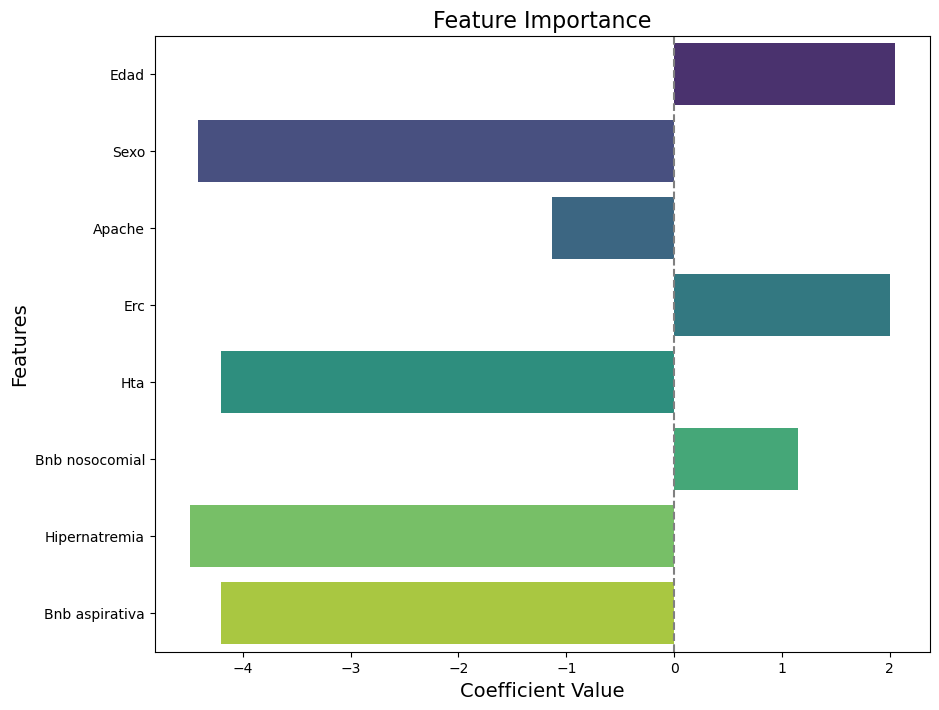

In [7]:
with mlflow.start_run():

    grid = GridSearchCV(estimator=reg, param_grid=params, scoring='neg_mean_squared_error', cv=5)
    grid.fit(X, y)

    mlflow.log_param('model_type', 'regression')
    for param, value in grid.best_params_.items():
        mlflow.log_param(param, value)
    
    mlflow.log_metric("best_score", np.sqrt(-grid.best_score_))
    mlflow.sklearn.log_model(grid.best_estimator_, 'ElasticNet')

    print('Best score: ', np.sqrt(-grid.best_score_))
    print('Best params: ', grid.best_params_)

    coefficients = grid.best_estimator_.named_steps['estimator'].coef_

    plt.figure(figsize=(10, 8))
    sns.barplot(x=coefficients, y=X.columns, palette='viridis') 
    plt.title('Feature Importance', fontsize=16)
    plt.xlabel('Coefficient Value', fontsize=14)
    plt.ylabel('Features', fontsize=14)
    plt.axvline(0, color='grey', linestyle='--')

    mlflow.log_figure(plt.gcf(), 'feature_importance.png')
    plt.show()